<a href="https://colab.research.google.com/github/mattagnew/SIT796-Reinforcement-Learning/blob/main/Task_4_2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 4.2P**

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
# USEFUL FUNCTIONS
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def policy_win_rate(Q, episodes=10000):
    wins = 0
    for episode in range(episodes):
        state = env.reset()
        
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
            
        if reward > 0:
            wins += 1

    win_rate = wins / episodes   

    return win_rate

def moving_average(array_in, size_of_window):
    return np.convolve(array_in, np.ones(size_of_window), 'valid') / size_of_window    

#**Monte Carlo Control (On-Policy)**#

In [4]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [5]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # INITIALISE WIN RATE
    win_rate = []
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            win_rate.append(policy_win_rate(Q))
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, win_rate

In [6]:
# obtain the estimated optimal policy and action-value function
policy_on, Q_on, win_rate_on = mc_control(env, 500000, 0.015)

Episode 500000/500000.

#**Monte Carlo Control (Off-Policy)**#

In [7]:
# RANDOM POLICY
def create_policy_random(nA):
    A = np.ones(nA) / nA
    def policy_fn(obs):
        return A
    return policy_fn

# GREEDY POLICY
def create_policy_greedy(Q):
    def policy_fn(obs):
        actions = Q[obs]
        best_action = np.argmax(actions)
        A = np.zeros(len(actions))
        A[best_action] = 1.
        return A
    return policy_fn

In [8]:
def mc_control_off_policy(env, num_episodes, policy, discount_factor = 1.0):

    nA = env.action_space.n

    # INITIALISE WIN RATE
    win_rate = []

    # INITIALISE EMPTY DICTIONARY OF ARRAYS
    Q = defaultdict(lambda: np.zeros(nA)) # Q Table
    C = defaultdict(lambda: np.zeros(nA)) # Cumulative Weights Table

    # TARGET GREEDY POLICY
    target_policy = create_policy_greedy(Q)

    # LOOP OVER EPISODES
    for i_episode in range(1, num_episodes+1):
        obs = env.reset()

        # MONITOR PROGRESS
        if i_episode % 1000 == 0:
            win_rate.append(policy_win_rate(Q))

            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episodes = []
        for i in range(100):
            probs = policy(obs)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_obs, reward, done, _ = env.step(action)
            episodes.append((obs, action, reward))
            if done:
              break
            obs = next_obs

        G = 0.
        W = 1.

        for t in range(len(episodes))[::-1]:
            obs, action, reward = episodes[t]

            G = discount_factor * G + reward

            C[obs][action] += W

            Q[obs][action] += (W / C[obs][action]) * (G - Q[obs][action])

            if action != np.argmax(target_policy(obs)):
                break

            W = W * 1./policy(obs)[action]

    return target_policy, Q, win_rate

In [9]:
random_policy = create_policy_random(env.action_space.n)
policy_off, Q_off, win_rate_off = mc_control_off_policy(env, num_episodes = 500000, policy = random_policy)

Episode 500000/500000.

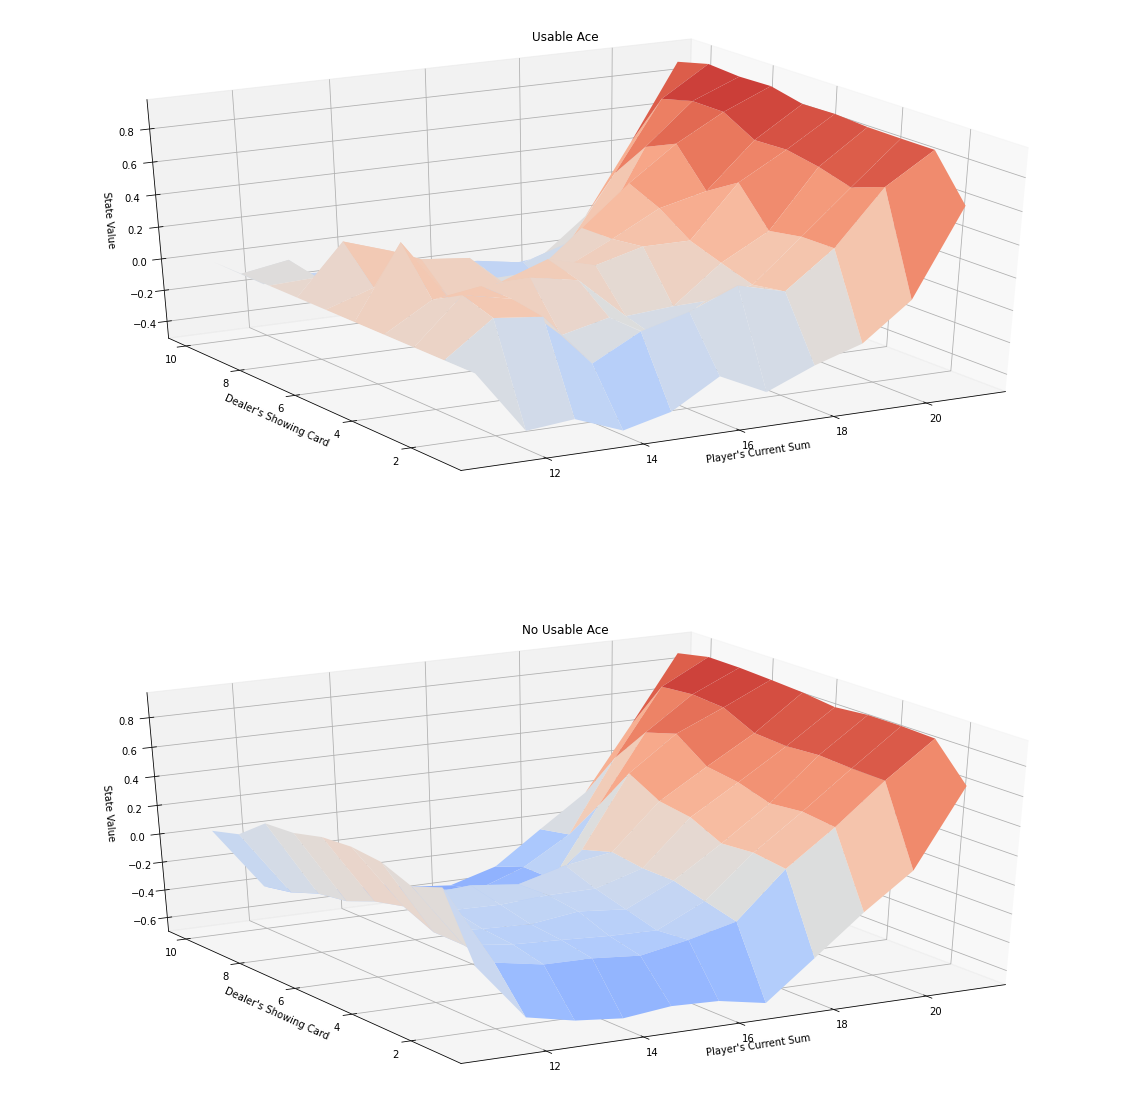

In [10]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_off.items())

# plot the state-value function
plot_blackjack_values(V)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


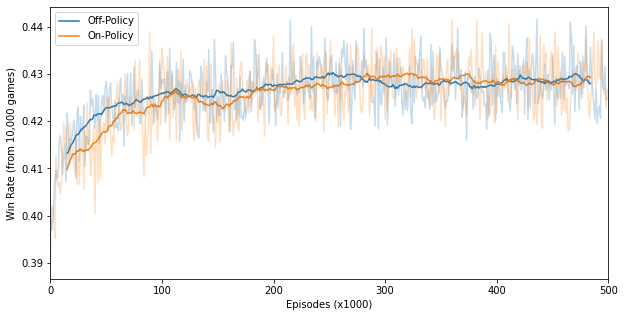

In [11]:
moving_average_size = 31
alpha_value = 0.25
shifted_x = np.arange(int((moving_average_size-1)/2),len(moving_average(win_rate_on,moving_average_size))+int((moving_average_size-1)/2))

colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(10,5))
ax = plt.gca()

mc_off = ax.plot(shifted_x, moving_average(win_rate_off,moving_average_size),c=colours[0])
mc_on = ax.plot(shifted_x, moving_average(win_rate_on,moving_average_size),c=colours[1])
ax.plot(win_rate_off,c=colours[0],alpha=alpha_value)
ax.plot(win_rate_on,c=colours[1],alpha=alpha_value)


plt.xlabel("Episodes (x1000)")
plt.ylabel("Win Rate (from 10,000 games)")
plt.xlim(0, 500)

plt.legend((mc_off, mc_on), labels=('Off-Policy','On-Policy'), loc="best")